In [96]:
# Install mamba_ssm package
!pip install mamba_ssm

In [97]:
# Imports
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import TensorDataset, DataLoader
from mamba_ssm import Mamba
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

In [98]:
# Load the dataset
dataset_path = '/kaggle/input/spotifydataset/SpotifyDataset.csv'
songs = pd.read_csv(dataset_path)

# Load features and target
feature_names = ['acousticness', 'danceability', 'duration_ms', 'energy', 'instrumentalness',
                 'key', 'liveness', 'loudness', 'mode', 'speechiness', 'tempo',
                 'time_signature', 'valence']
x = songs[feature_names]
y = songs['popularity'].values

# Split data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

# Standardize certain features
cols_to_standardize = ['duration_ms', 'loudness', 'tempo', 'energy', 'liveness']
x_scaler = StandardScaler()
x_train[cols_to_standardize] = x_scaler.fit_transform(x_train[cols_to_standardize])
x_test[cols_to_standardize] = x_scaler.transform(x_test[cols_to_standardize])
x_train = x_train.values
x_test = x_test.values

# Create TensorDataset from numpy arrays
songs_tensor_train_ds = TensorDataset(torch.tensor(x_train, dtype=torch.float).unsqueeze(1), torch.tensor(y_train, dtype=torch.float))

In [99]:
# Model definition
class MambaModel(nn.Module):
    def __init__(self, input_dim, output_dim, d_state=16, d_conv=4, expand=2):
        super(MambaModel, self).__init__()
        self.mamba = Mamba(
            d_model=input_dim,
            d_state=d_state,
            d_conv=d_conv,
            expand=expand
        )
        self.relu = nn.ReLU()
        self.output_layer = nn.Linear(input_dim, output_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.mamba(x)
        x = self.relu(x)
        x = self.output_layer(x)
        x = self.sigmoid(x)
        return x * 100

In [100]:
# Hyperparameters
num_features = x_train.shape[1]
output_dim = 1
learning_rate = 0.00001
num_epochs = 450
# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")  
# Loss criterion
criterion = nn.MSELoss()
# Model instantiation
model = MambaModel(input_dim = num_features, output_dim = output_dim).to(device)
print(model)
# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

MambaModel(
  (mamba): Mamba(
    (in_proj): Linear(in_features=13, out_features=52, bias=False)
    (conv1d): Conv1d(26, 26, kernel_size=(4,), stride=(1,), padding=(3,), groups=26)
    (act): SiLU()
    (x_proj): Linear(in_features=26, out_features=33, bias=False)
    (dt_proj): Linear(in_features=1, out_features=26, bias=True)
    (out_proj): Linear(in_features=26, out_features=13, bias=False)
  )
  (relu): ReLU()
  (output_layer): Linear(in_features=13, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


Epoch: 0 Loss: 368.7577092488607
Epoch: 50 Loss: 234.05360539754233
Epoch: 100 Loss: 154.72074457804362
Epoch: 150 Loss: 133.22707087198893
Epoch: 200 Loss: 123.8524939219157
Epoch: 250 Loss: 120.15350977579753
Epoch: 300 Loss: 118.23095970153808
Epoch: 350 Loss: 116.92488327026368
Epoch: 400 Loss: 116.320201365153


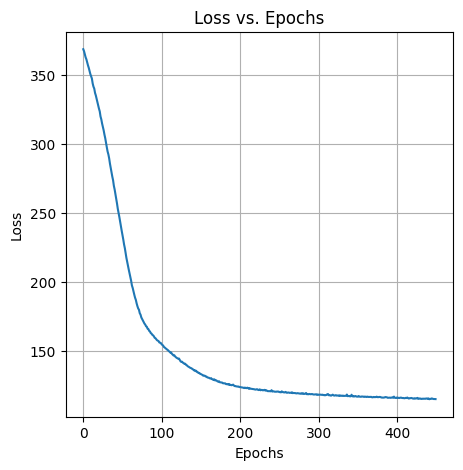

Train error: 94.88119506835938
Test error: 106.44230651855469


In [101]:
# Model training
tensor_train_dataloader = DataLoader(songs_tensor_train_ds, batch_size=64, shuffle=True)
losses = []
for epoch in range(num_epochs):
    model.train()
    epoch_losses = []
    for features, target in tensor_train_dataloader:
        features = features.to(device)
        target = target.to(device)
        output = model(features)
        loss = criterion(output.view(-1), target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_losses.append(loss.item())
    if epoch % 50 == 0:
        print(f"Epoch: {epoch} Loss: {np.mean(epoch_losses)}")
    losses.append(np.mean(epoch_losses))

# Plot loss
fig = plt.figure(figsize=(5, 5))
plt.plot(losses)
plt.grid(True)
plt.title("Loss vs. Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

# Model testing
model.eval()
with torch.no_grad():
    test_outputs = model(torch.tensor(x_test, dtype=torch.float, device=device).unsqueeze(1))
    test_error = criterion(test_outputs.view(-1), torch.tensor(y_test, dtype=torch.float, device=device))

# Print the errors
print(f"Train error: {loss.item()}")
print(f'Test error: {test_error.item()}')

In [104]:
# Compare with Linear Regression
linReg = LinearRegression()
linReg.fit(x_train, y_train)

# Predict the test data
y_pred = linReg.predict(x_test)
# Calculate error for the test data
test_mse = mean_squared_error(y_test, y_pred)

# Predict the train data
y_train_pred = linReg.predict(x_train)
# Calculate error for the train data
train_mse = mean_squared_error(y_train, y_train_pred)

# Print the errors
print(f'Train error: {train_mse}')
print(f'Test error: {test_mse}')

Train error: 111.56909682762813
Test error: 105.23763580186127
